#### Import

In [1]:
import sys
sys.path.insert(0,'..')
import urx
import time
import math3d as m3d
ur = urx.Robot("192.168.1.10", use_rt=True)
pose = ur.get_pose()
print(pose)
from ddh import DDGripper
from scooping_primitives import HighSpeedScooping
from data_logger import DataLogger
from jupyterthemes import jtplot
white = 0
if white:
    jtplot.style(theme='default', figsize=(25, 8))
else:
    jtplot.style(figsize=(25, 8))

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68


importing urx from /high_speed_scooping


tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


<Transform:
<Orientation: 
array([[ 1.00000000e+00, -2.96441408e-05,  8.50293771e-06],
       [-2.91597040e-05, -8.19126948e-01,  5.73612275e-01],
       [-1.00392576e-05, -5.73612274e-01, -8.19126949e-01]])>
<Vector: (-0.02161, 0.70001, 0.47738)>
>


In [2]:
gripper = DDGripper("ddh_scooping")
scoop = HighSpeedScooping(ur, gripper, "hss_card_fast")
logger = DataLogger(ur, gripper, scoop)

reading gripper config...
connecting to odrive...
found left finger
found right fingers
reading scooping config...


In [3]:
scoop.initialize_pose((-0.505,0.45,180))
# gripper.disarm('L') # for fragile
# scoop.initialize_pose((0,0.7,180)) # video wide view

Setting left tip: (131.4161234622261, 61.54052623496334)
Setting right tip: (102.61111482867656, 32.67834189915651)
Setting pose: 
[-0.5266      0.45        0.45       -1.8724501  -1.8724501   0.59038125]


Start logging
Collision detected!
Setting left tip: (155, 47)
Setting right tip: (155, -47)
Reached zero speed!
==========Scooping completed!==========
Speed at collision: -0.47105 m/s
Distance to decelerate: 0.04884 m
Deceleration for lifting: 11.09430 m/s^2
Slept time for lifting: 0.98 s
Lifted distance: 0.49644 m
Stop logging
Collision time: 1620 ms


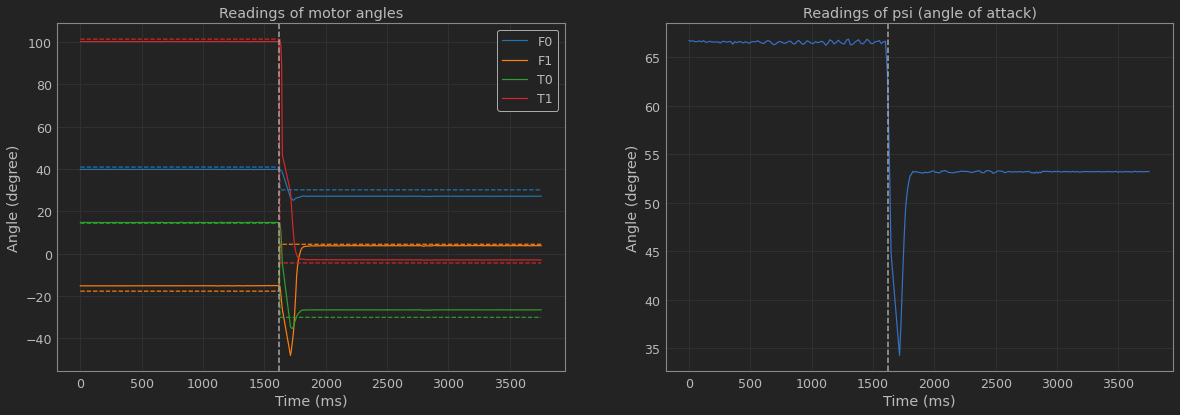

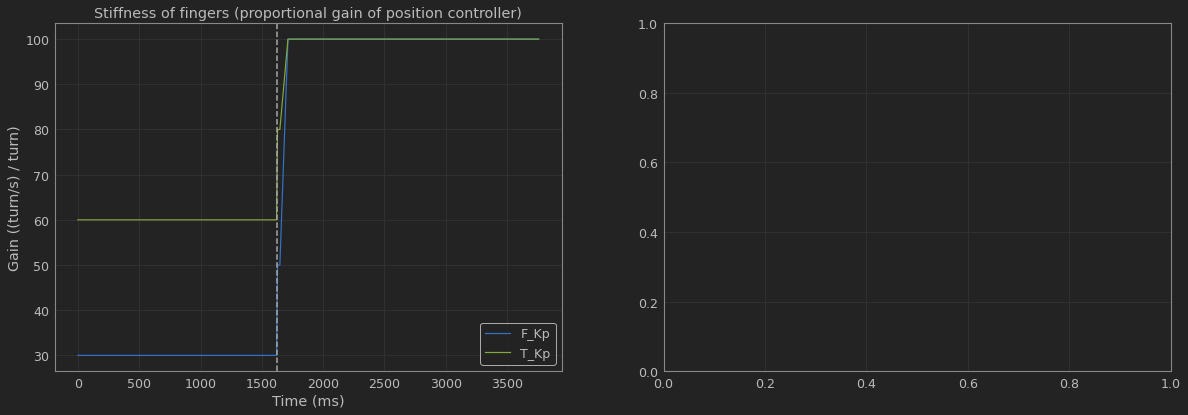

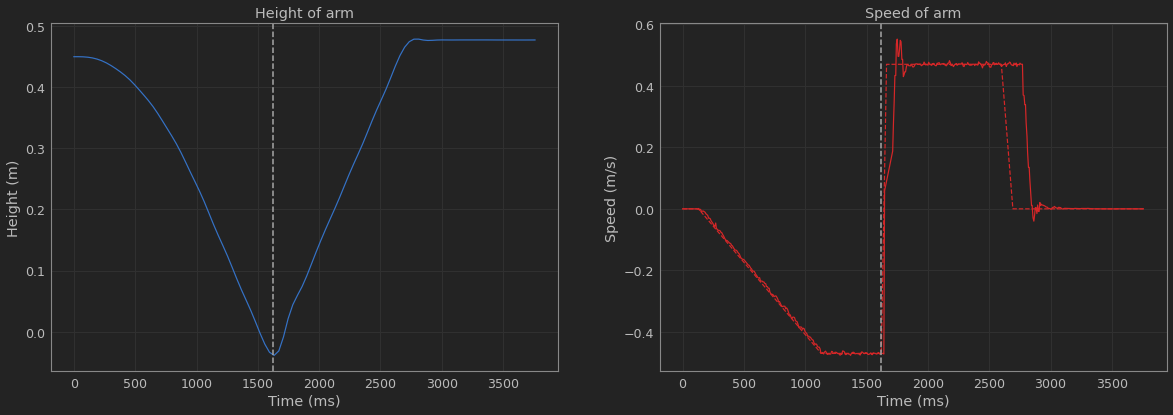

In [30]:
logger.logged = True
scoop.simple_scoop()
logger.logged = False
logger.plot_data(False)

#### picking book from wall, side scoop

In [62]:
scoop.wall_init(-0.15, 8, True)

Setting left tip: (105.16904145236427, -24.914478560499248)
Setting right tip: (157.5343583888875, -20.06213335917993)
Setting pose: 
[-0.1695      0.77        0.195      -1.70212414  0.79371352  1.70212414]


In [61]:
scoop.wall_scoop(True)

Collision detected!
Setting left tip: (145, 60)
Setting right tip: (145, -60)
Reached zero speed!
==========Scooping completed!==========
Speed at collision: 0.29993 m/s
Distance to decelerate: 1.03860 m
Deceleration for lifting: 4.49789 m/s^2
Slept time for lifting: 0.00 s
Lifted distance: 0.77002 m


#### picking book from wall 

In [63]:
scoop.wall_init(-0.2, 20)

Setting left tip: (114.361574769792, -32.62792987673771)
Setting right tip: (157.5343583888875, -20.06213335917993)
Setting pose: 
[-0.2         0.77        0.0305     -2.26892803  0.          0.        ]


In [7]:
scoop.wall_scoop()

Collision detected!
Setting left tip: (145, 60)
Setting right tip: (145, -60)
Reached zero speed!
==========Scooping completed!==========
Speed at collision: 0.30280 m/s
Distance to decelerate: 1.03865 m
Deceleration for lifting: 2.29225 m/s^2
Slept time for lifting: 0.00 s
Lifted distance: 0.99913 m


#### gripper demo

In [9]:
from ddh import DDGripper
gripper = DDGripper("ddh_scooping")

reading gripper config...
connecting to odrive...
found left finger
found right fingers


In [10]:
gripper.arm(pos_gain = 50)

In [18]:
gripper.startup_dance()

In [7]:
gripper.disarm()

#### Input Bandwidth Testing

In [1]:
import sys
sys.path.insert(0,'..')
import urx
import time
import math3d as m3d
ur = urx.Robot("192.168.1.10", use_rt=True)
pose = ur.get_pose()
print(pose)
from ddh import DDGripper
from scooping_primitives import HighSpeedScooping
from data_logger import DataLogger
from jupyterthemes import jtplot
white = 0
if white:
    jtplot.style(theme='default', figsize=(25, 8))
else:
    jtplot.style(figsize=(25, 8))
gripper = DDGripper("ddh_scooping")
scoop = HighSpeedScooping(ur, gripper, "hss_card_fast")
logger = DataLogger(ur, gripper, scoop)

importing urx from /high_speed_scooping


tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


<Transform:
<Orientation: 
array([[ 0.00461031,  0.82051626, -0.5716046 ],
       [ 0.99995542, -0.0084933 , -0.0041266 ],
       [-0.00824075, -0.57156009, -0.82051883]])>
<Vector: (-0.42683, 0.44967, 0.63971)>
>
reading gripper config...
connecting to odrive...
found left finger
found right fingers
reading scooping config...


In [8]:
gripper.arm(pos_gain=100)
gripper.set_left_tip((131.4161234622261, 61.54052623496334))
gripper.set_right_tip((102.61111482867656, 32.67834189915651))

Setting left tip: (131.4161234622261, 61.54052623496334)
Setting right tip: (102.61111482867656, 32.67834189915651)


Start logging
Setting left tip: (155, 47)
Setting right tip: (155, -47)
Stop logging


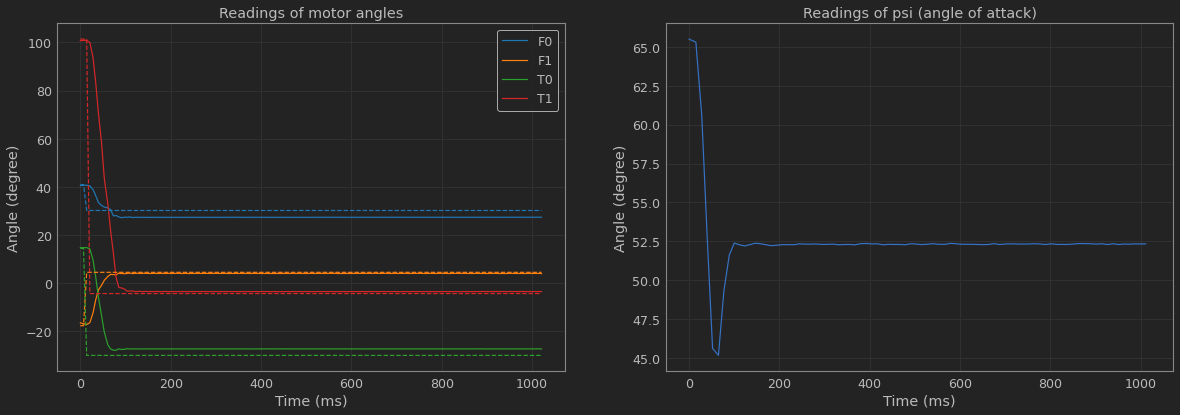

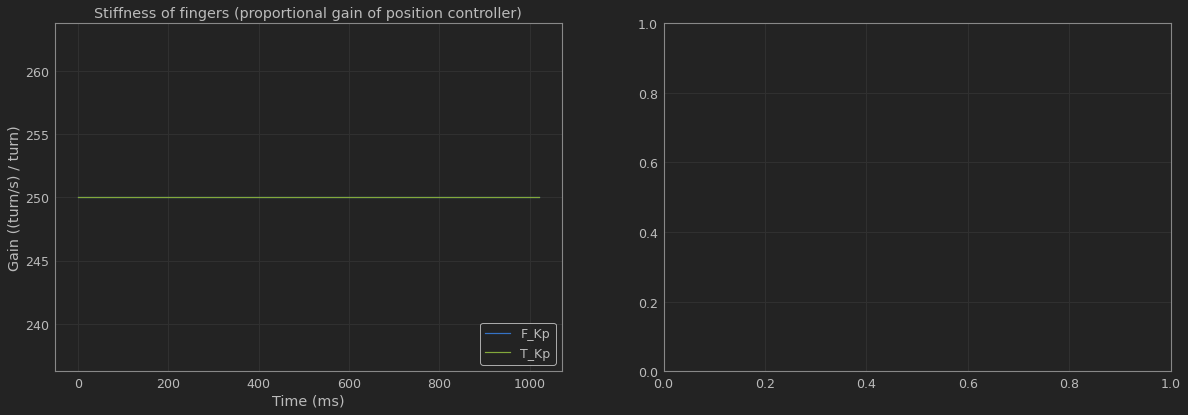

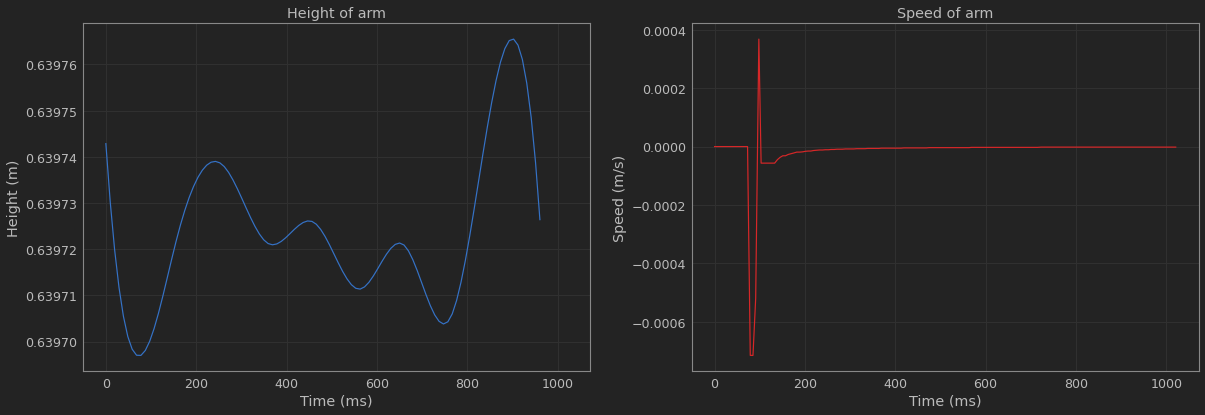

In [9]:
logger.logged = True
gripper.arm(BW=100)
gripper.set_left_tip((155, 47))
gripper.set_right_tip((155, -47))
time.sleep(1)
logger.logged = False
logger.plot_data(True)

In [6]:
gripper.set_left_tip((157, 40))
gripper.set_right_tip((157, -40))

Setting left tip: (157, 40)
Setting right tip: (157, -40)


In [ ]:
logger.logged = True
gripper.arm(BW=100)
gripper.set_left_tip((150,0))
gripper.set_right_tip((150,0))
time.sleep(1)
logger.logged = False
logger.plot_data(True)

#### gripper pose testing

In [4]:
# book grasp
gripper.arm(pos_gain=300)
gripper.set_left_tip((145, 60))
gripper.set_right_tip((145, -60))
# gripper.set_parallel_jaw(-14.5, 0)

Setting left tip: (145, 60)
Setting right tip: (145, -60)


In [26]:
gripper.disarm()

In [5]:
gripper.set_left_tip((140, 20))
gripper.set_right_tip((140, -20))

Setting left tip: (140, 20)
Setting right tip: (140, -20)


In [ ]:
gripper.set_left_tip((158, 38))
gripper.set_right_tip((158, -38))